In [1]:
!pip install causalml catboost

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from catboost import CatBoostClassifier

from google.colab import drive
drive.mount('/content/drive', force_remount=True)
DIR_DATA = './drive/MyDrive/Stud/SkillFactory/sf_uplift/'

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [3]:
fname = DIR_DATA+"criteo-uplift-v2.1.csv"
df = pd.read_csv(fname)
df = df.tail(850000)
df.sort_values('treatment', inplace=True)
df = df.head(80000)

In [4]:
df.treatment.value_counts()

1    41086
0    38914
Name: treatment, dtype: int64

In [5]:
df.visit.value_counts()

0    74595
1     5405
Name: visit, dtype: int64

In [6]:
df.exposure.value_counts()

0    77863
1     2137
Name: exposure, dtype: int64

In [7]:
# Возьмем функцию для оценки Qini curve
def qini_df(df):
    # 1. Отранжируем выборку по значению uplift в убывающем порядке
    ranked = df.sort_values("uplift_score", ascending=False)
    
    N_c = sum(ranked['visit'] == 0)
    N_t = sum(ranked['visit'] == 1)
    
    # Посчитаем в отсортированном датафрейме основные показатели, которые используются при расчете qini
    ranked['n_c1'] = 0
    ranked['n_t1'] = 0
    ranked.loc[ranked.exposure == 0,'n_c1'] = 1
    ranked.loc[ranked.exposure == 1,'n_t1'] = 1
    ranked['n_c1/nc'] = ranked.n_c1.cumsum() / N_c
    ranked['n_t1/nt'] = ranked.n_t1.cumsum() / N_t
    
    # Посчитаем qini curve и рандомную прямую под ней
    ranked['uplift'] = round(ranked['n_t1/nt'] - ranked['n_c1/nc'],5)
    # Добавим случайную кривую
    ranked['random_uplift'] = round(ranked["uplift_score"].rank(pct=True, ascending=False) * ranked['uplift'].iloc[-1],5)
    
    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # Немного кода для визуализации
    plt.plot(ranked['n'], ranked['uplift'], color='r')
    plt.plot(ranked['n'], ranked['random_uplift'], color='b')
    plt.show()
    
    return (ranked['uplift'] - ranked['random_uplift']).sum()

In [8]:
# Вынесем колонки с факторами, тритментом и таргетом
feature_cols = ['f0', 'f1', 'f2', 'f3', 'f4',
                'f5', 'f6', 'f7',
                'f8', 'f9', 'f10', 'f11']
target_col = 'visit'
treatment_col = 'treatment'

In [9]:
# Разобъем нашу выборку на тестовую и валидационную
df_train, df_test = train_test_split(
    df, shuffle=True, random_state=13, 
    test_size=0.3
)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


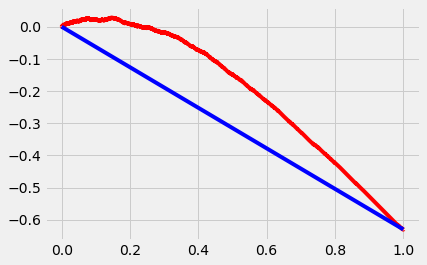

2716.5737799999997

In [10]:
# Давайте по данным построим S-learner

# Создадим базовый S-learner
s_learner = BaseSClassifier(learner=LogisticRegression(random_state=42))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
s_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

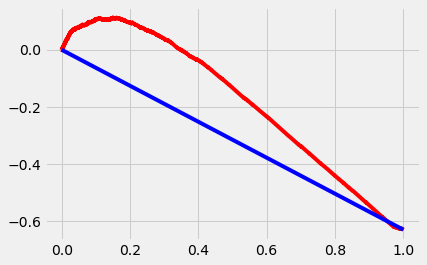

3280.63447

In [11]:
# Давайте по данным построим T-learner

# Создадим базовый T-learner
t_learner = BaseTClassifier(learner=LogisticRegression(random_state=42))

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
t_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения в рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

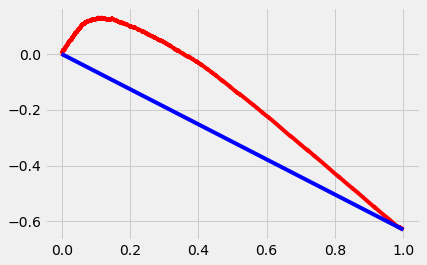

3511.42265

In [12]:
# Давайте по данным построим X-learner

# Создадим базовый X-learner
x_learner = BaseXClassifier(outcome_learner=LogisticRegression(random_state=42),
                           effect_learner=LinearRegression())

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
x_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = x_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

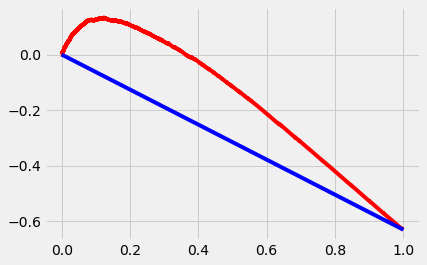

3670.31094

In [13]:
# Давайте по данным построим R-learner

# Создадим базовый T-learner
r_learner = BaseRClassifier(outcome_learner=LogisticRegression(random_state=42),
                            effect_learner=LinearRegression())

# Для обучения нам нужны датафрем с факторами, колонка с фактом воздействия
r_learner.fit(X=df_train[feature_cols],
              treatment=df_train[treatment_col],
              y=df_train[target_col])

uplift_vals = r_learner.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

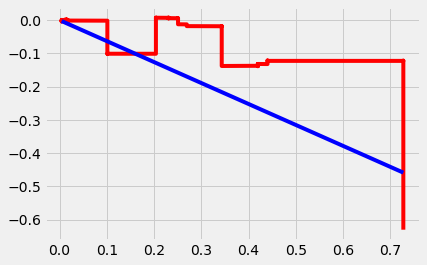

2032.4819000000002

In [14]:
# Учим простое дерево. Обратим внимание, что для деревьев из CausalMl не нужно трансформировать целевые переменные
uplift_model = UpliftTreeClassifier(max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='ED', control_name='0')

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

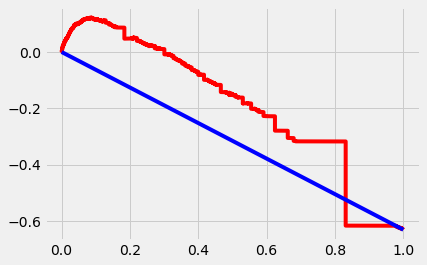

3075.2199599999994

In [15]:
# Давайте построим случайный лес

uplift_model = UpliftRandomForestClassifier(
    max_depth=5, min_samples_leaf=200, min_samples_treatment=50,
    n_reg=100, evaluationFunction='ED', control_name='0'
)

uplift_model.fit(df_train[feature_cols].values,
                 treatment=df_train[treatment_col].apply(str).values,
                 y=df_train[target_col].values)

uplift_vals = uplift_model.predict(np.array(df_test[feature_cols].values.copy()))

# Мы получили какие-то значения рамках решения задачи классификации, давайте посмотрим на qini score
df_test['uplift_score'] = uplift_vals
qini_df(df_test)

In [17]:
# Result (lower = better):
# 2716.57377 - S
# 3280.63447 - T
# 3511.42265 - X
# 3670.31094 - R
# 2032.48190 - tree (!)
# 3075.21995 - random forest